In [5]:
!pip install yfinance
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.5 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
ADF Statistic: -1.1033776262773993
p-value: 0.7137230688785169
Critical Values:
1%: -3.5137900174243235
5%: -2.8979433868293945
10%: -2.5861907285474777


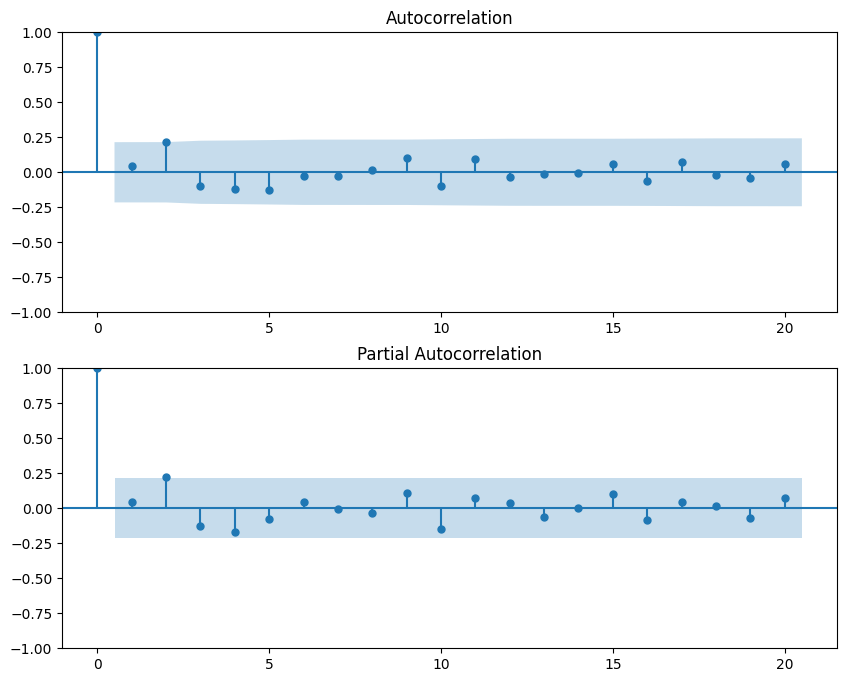

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=973.253, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=971.625, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=973.286, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=970.581, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=975.187, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.423 seconds


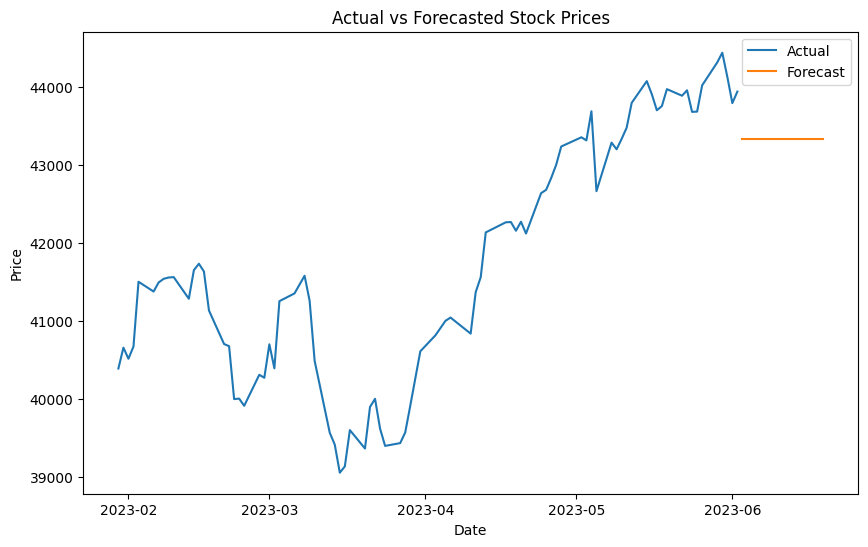

In [33]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pmdarima as pm
from datetime import timedelta
from sklearn.metrics import accuracy_score
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm


import warnings

warnings.filterwarnings("ignore")

def arima_pred(tickers):
   
    today = datetime.today().strftime('%Y-%m-%d')
    
    df = yf.download(tickers, start='2023-01-30', end=today,group_by='ticker')
    
  
    df_close = df.filter(['Close'])
    
    df_log = np.log(df_close)

    result = sm.tsa.stattools.adfuller(df_close)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key}: {value}')

    # Make the data stationary by differencing
    differenced_prices = df_close.diff().dropna()

    # Determine the order of the ARIMA model
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    sm.graphics.tsa.plot_acf(differenced_prices, ax=ax1)
    sm.graphics.tsa.plot_pacf(differenced_prices, ax=ax2)
    plt.show()
    
    # train_data, test_data = df_close[3:int(len(df_close)*0.7)], df_close[int(len(df_close)*0.7):]
    train_data, test_data = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]

    training_data = train_data['Close'].values
    
    


    smodel = pm.auto_arima(training_data,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                information_criterion='aic',
                                start_p=1,
                                start_d=0,
                                start_q=0,
                                lags=323,
                                seasonal=False,
                                trace=True)
    smodel.summary()


    n_periods = 1
    fitted, confint = smodel.predict(n_periods=len(test_data[:20]), return_conf_int=True)
   
    index_of_fc = pd.date_range(test_data.index[-1] + timedelta(days=1), periods = len(test_data[:20]))

    fitted_series = pd.Series(fitted, index=index_of_fc)

    roundd = round(fitted_series,2)


    X_FUTURE = 1
    dicts = []
    curr_date = test_data.index[-1]
    
    for i in range(X_FUTURE):
        curr_date = curr_date + timedelta(days=1)
        
        dicts.append({'Predictions':roundd[-(i+1)] ,"Date": str(curr_date.date())})
       

    new_data = pd.DataFrame(dicts).set_index("Date")


    plt.figure(figsize=(10, 6))
    plt.plot(df_close, label='Actual')
    plt.plot(fitted_series, label='Forecast')
    plt.title('Actual vs Forecasted Stock Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

    # return arima_dic
arima_pred("^NSEBANK")